In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from importlib import reload

import copy
import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *
from scoobpsf import scoob

import lina

pupil_diam = 6.75*u.mm 
lyot_diam = 8.6*u.mm

# The flattest wavefront obtained for the system in the lab by
# performing phase diversity
dm_flat = fits.getdata(scoob.module_path/'scoob_dm_flat.fits')

wavelength_c = 632.8e-9*u.m # central wavelength
npix = 512
oversample = 16

vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0)

In [4]:
type(xp.array([0]))

cupy.ndarray

In [5]:
poppy.xp

<module 'cupy' from '/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/cupy/__init__.py'>

In [76]:
model = scoob.SCOOBM(npix=npix, oversample=oversample,
                     use_synthetic_opds = True,
                     )

# static_wfe, mask = lina.utils.generate_wfe(model.pupil_diam, wavelength=500*u.nm,
#                                             opd_index=2.75, amp_index=3.0, 
#                                             opd_seed=1234, amp_seed=12345,
#                                             opd_rms=10*u.nm, amp_rms=0.05,
#                                             npix=model.npix, oversample=1,
#                                             remove_modes=5,
#                                             )

# wfe_amp = xp.abs(static_wfe)
# wfe_opd = xp.angle(static_wfe)*model.wavelength_c.to_value(u.m)/2/np.pi
# imshow2(wfe_amp, wfe_opd, )

# WFE = poppy.ArrayOpticalElement(transmission=copy.copy(wfe_amp), opd=copy.copy(wfe_opd),
#                                  pixelscale=model.pupil_diam/(model.npix*u.pix))

# model.WFE = WFE

model.LYOT = lyot_stop

Model using synthetic OPD data
Using default Gaussian influence function.
Including factor of 2 from reflection when computing OPD.


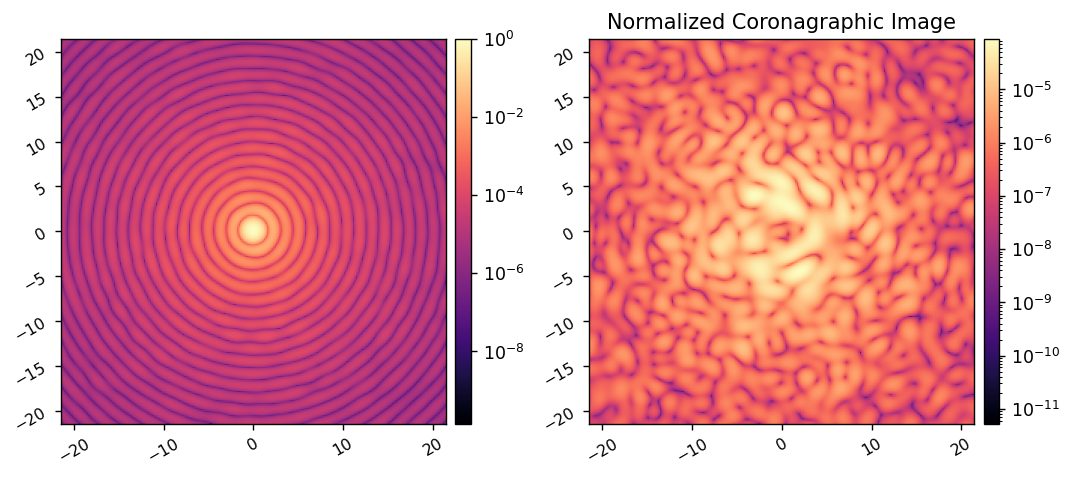

In [77]:
reload(scoob)

im0 = model.snap()
model.Imax_ref = im0.max()

ref_unocc_im = model.snap()

model.FPM = vortex

ref_im = model.snap()
imshow2(ref_unocc_im, ref_im, '', 'Normalized Coronagraphic Image', 
        lognorm=True, 
        pxscl=model.psf_pixelscale_lamD)

In [78]:
%%timeit
ref_im = model.snap()


1.95 s ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
model.psf_pixelscale_lamD

0.16765050386400812

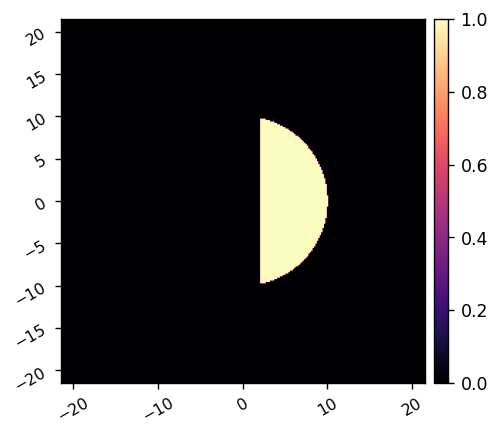

In [79]:
reload(lina.utils)
iwa = 2
owa = 10
edge = 2
control_mask = lina.utils.create_annular_focal_plane_mask(model, iwa, owa, edge=edge, shift=(0,0), rotation=0)
imshow1(control_mask, pxscl=model.psf_pixelscale_lamD)

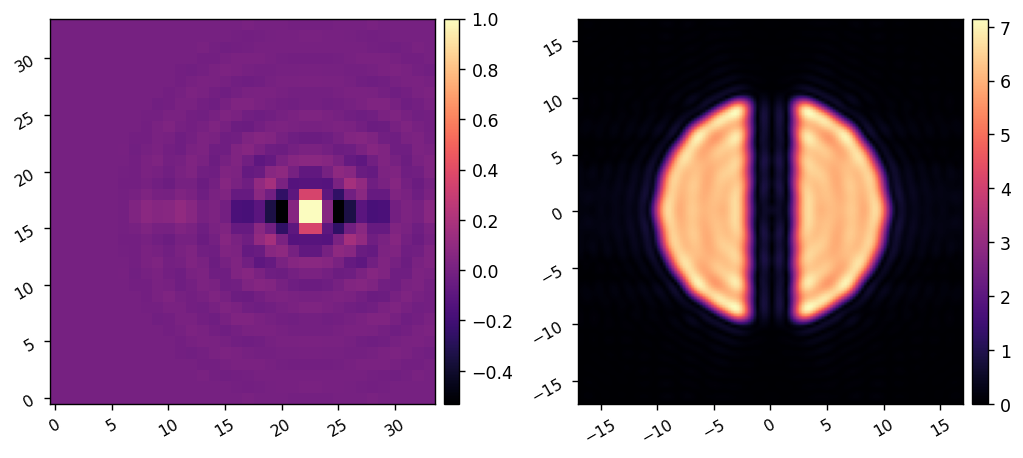

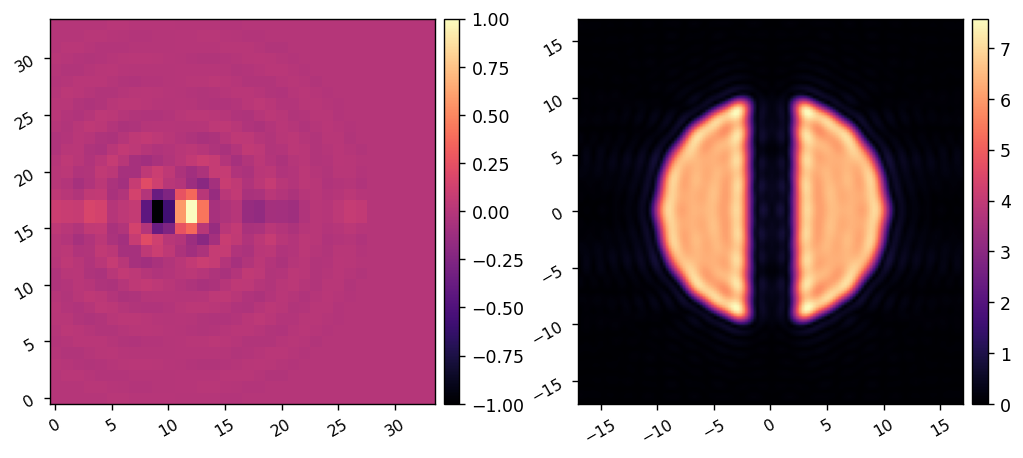

In [21]:
probe_amp = 10e-9
probe_modes = lina.utils.create_fourier_probes(model, control_mask, fourier_sampling=0.25, 
                                               shift=[(6,0), (-6,0)], 
                                               nprobes=2, 
                                               plot=True, )
probe_modes = xp.array(probe_modes)

236

118

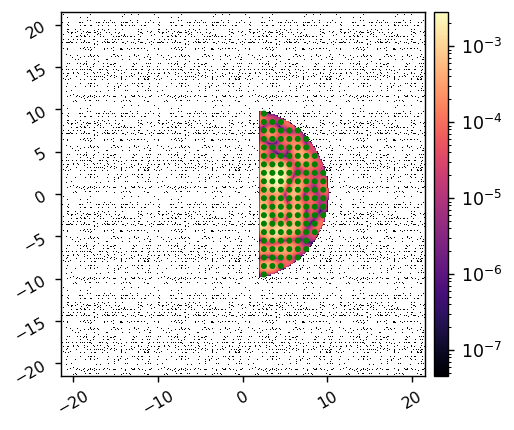

In [22]:
reload(lina.utils)

calib_amp = 5e-9
calib_modes, fs = lina.utils.create_fourier_modes(model, control_mask, fourier_sampling=1, return_fs=True) 
calib_modes = xp.array(calib_modes)
nmodes = calib_modes.shape[0]
nf = nmodes//2
display(nmodes, nf)

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))
    
imshow1(ref_im*control_mask, lognorm=True, pxscl=model.psf_pixelscale_lamD, patches=patches)

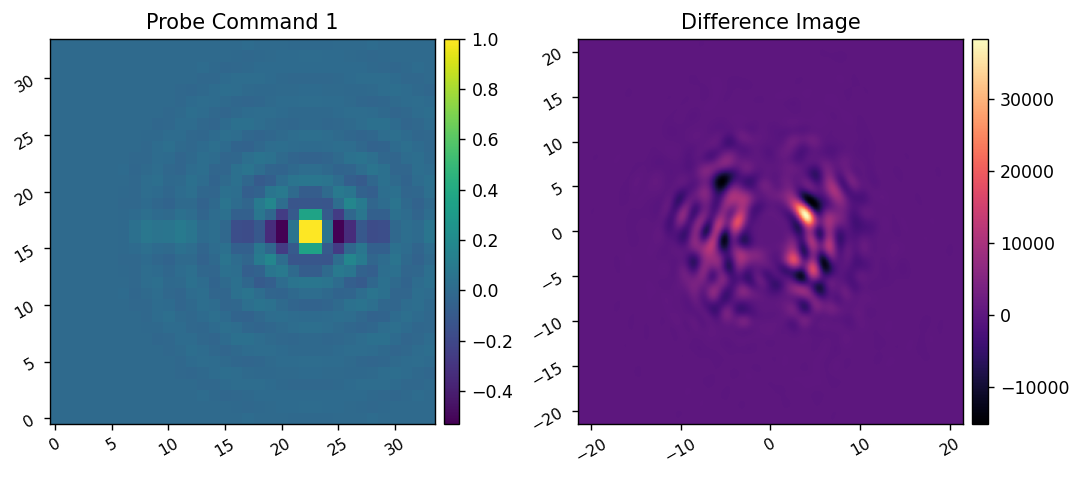

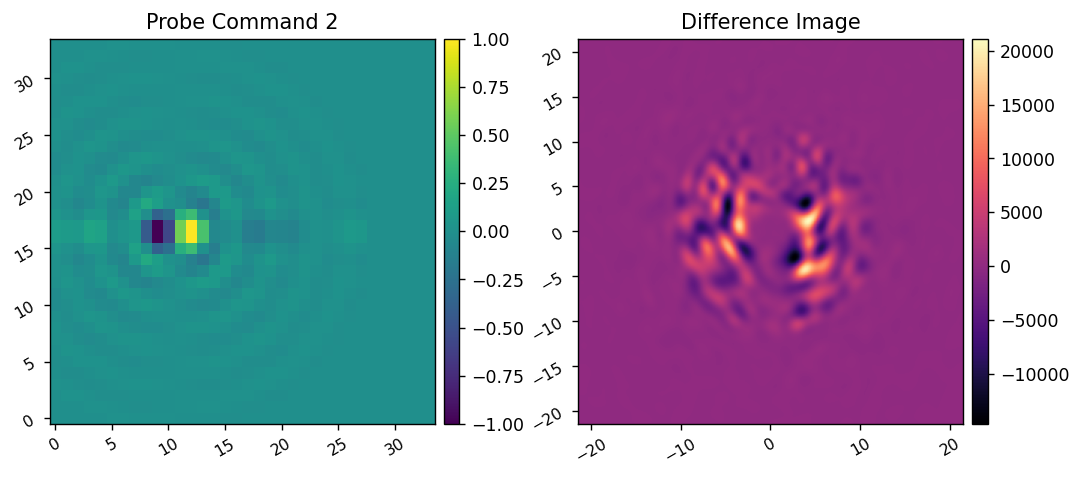

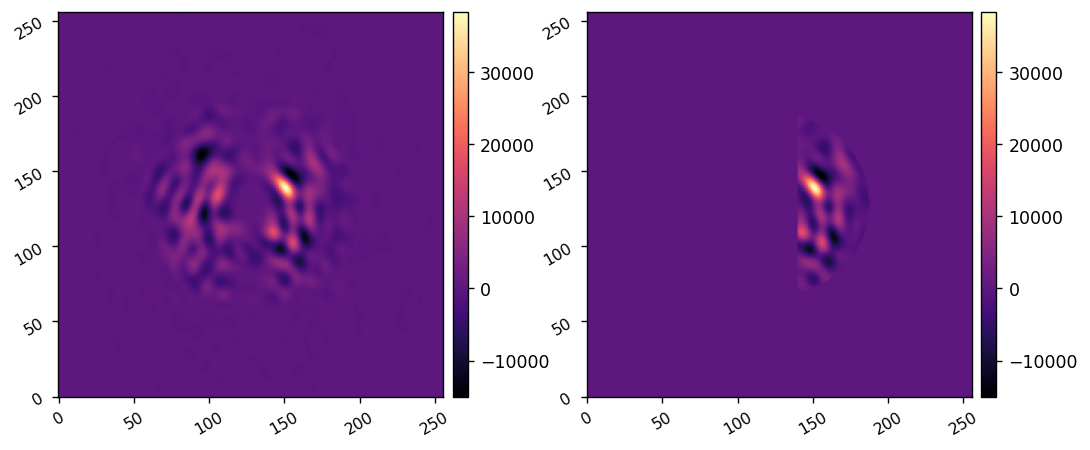

In [25]:
reload(lina.iefc)
model.reset_dm()
differential_images = lina.iefc.take_measurement(model, xp.array(probe_modes), probe_amp, plot=True)
imshow2(differential_images[0].reshape(model.npsf, model.npsf), 
        differential_images[0].reshape(model.npsf, model.npsf)*control_mask)


In [26]:
model.psf_pixelscale_lamD, model.psf_pixelscale

(0.16765050386400812, <Quantity 3.76 um / pix>)

In [27]:
reload(lina.iefc)
model.reset_dm()
response_matrix, response_cube = lina.iefc.calibrate(model, control_mask, 
                                                     probe_amp, probe_modes, 
                                                     calib_amp, calib_modes, 
                                                     return_all=True)

Calibrating iEFC...
	Calibrated mode 236 / 236 in 1860.15s
Calibration complete.


In [28]:
response_matrix.shape, response_cube.shape

((7152, 240), (240, 2, 65536))

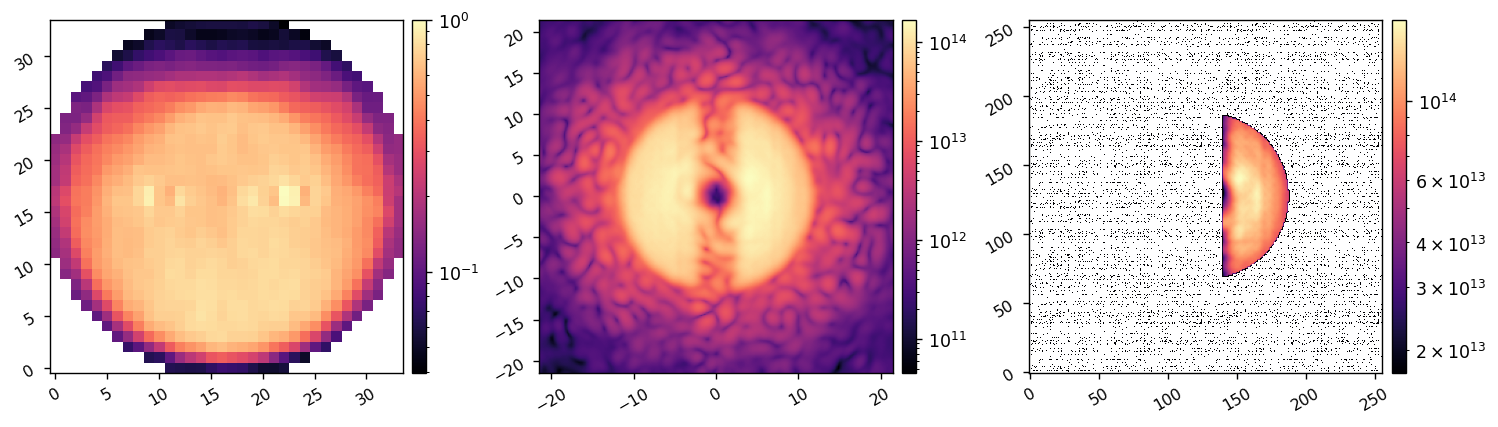

In [28]:
rms_responses = xp.sqrt(xp.mean(xp.square(response_matrix.dot(calib_modes)), axis=0)).reshape(model.Nact, model.Nact)
rms_responses /= xp.max(rms_responses)
fp_response = xp.sum(abs(response_cube), axis=(0,1)).reshape(model.npsf,model.npsf)
imshow3(rms_responses, fp_response, control_mask*fp_response, lognorm=True, pxscl2=model.psf_pixelscale_lamD)

In [56]:
fwf = poppy.FresnelWavefront(beam_radius=9.2*u.mm/2, npix=512, oversample=2, wavelength=wavelength_c,)

In [67]:
Nact = model.Nact
model.set_dm(1e-9*xp.ones((Nact, Nact)))

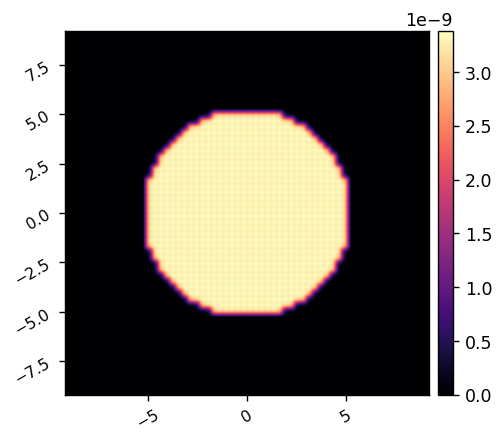

In [68]:
dm_opd = model.DM.get_opd(fwf)
imshow1(dm_opd, pxscl=fwf.pixelscale.to_value(u.mm/u.pix))

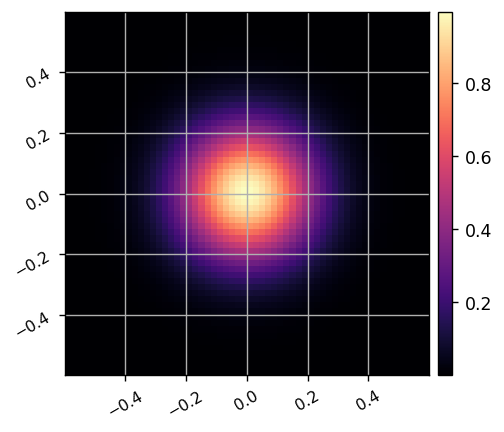

In [63]:
imshow1(model.DM.inf_fun, pxscl=model.DM.inf_pixelscale.to(u.mm/u.pix), grid=True)

In [66]:
reload(lina.iefc)
reload(lina.utils)
model.reset_dm()

probe_amp = 2e-9

reg_cond = -2.5

# control_matrix = lina.utils.WeightedLeastSquares(response_matrix, weight_map, nprobes=2, rcond=1e-3)
control_matrix = lina.utils.beta_reg(response_matrix, beta=reg_cond)
    
images, dm_commands = lina.iefc.run(model, 
                              control_matrix,
                              probe_modes, 
                              probe_amp, 
                              calib_modes,
                              control_mask, 
                              num_iterations=5, 
                              loop_gain=0.1, 
                              leakage=0.0,
                              plot_all=True,
                             )

Running iEFC ...
	Closed-loop iteration 1 / 5


KeyboardInterrupt: 